# Algorítmo de limpieza de potencia aparente de Circuitos

El presente algorítmo permitirá obtener valores de potencia aparente validada para almacenarla en el DWH, la estampa de tiempo de la validación es de 1 minuto.

### Pasos a seguir durante el proceso:

    - Limpieza de outliers con el Método: DBSCAN
    - Aplicación del algoritmo de validación de máximos y mínimos
    - Almacenamiento de los datos validados en el DWH

### Limpieza de outliers con el Método: DBSCAN

Utilizaremos la biblioreca **sklearn** la cual tiene listo el algoritmo DBSCAN para ser implementado.

In [1]:
### Importación de clases y paquetes

from GetCircuitos import GetCircuitos
from pyspark.sql.functions import to_timestamp, col, regexp_replace
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Obtención de los datos de Circuitos desde el HDFS ( POTENCIA DESTINO)

In [2]:
# Datos de entrada

fecha_inicio = datetime.datetime.strptime('2019-10-10 00:00', '%Y-%m-%d %H:%M')
fecha_fin = datetime.datetime.strptime('2019-10-10 23:59', '%Y-%m-%d %H:%M')
circuito = 'ESM230DOM1'
dimension = 'Potencia Aparente'

# Datos De circuitos (DataFrame Pyspark)

getCircuitos = GetCircuitos(TableName = '', FileName='circuitos_destino_*')
circuitosDestino = getCircuitos.GetDataDestino(fecha_inicio,fecha_fin,circuito)
print(circuitosDestino.columns)
circuitosDestino.select('circuito','TagPotenciaDestino').distinct().show(truncate=False)
tag = circuitosDestino.select('TagPotenciaDestino').distinct().first()[0]

# Datos a pandas dataframe

datosDestino = circuitosDestino.toPandas().set_index('Fecha')

['Id', 'circuito', 'Potencia', 'Calidad', 'TagCalidadDestino', 'TagPotenciaDestino', 'Fecha', 'LimMaxOperacion', 'LimOperacionContinuo', 'LimTermico', 'NumCircuitos']
+----------+---------------------------------+
|circuito  |TagPotenciaDestino               |
+----------+---------------------------------+
|ESM230DOM1|S_DOMING230ESMER_1_S.LINEA_CAL.AV|
+----------+---------------------------------+



#### Definición del Algoritmo DBSCAN, salida de datos outliers y datos limpios

In [3]:
# Método DBSCAN

def limpiar_outliers(datos,epsilon = 0.01, samples = 5):
    datos_totales = datos.copy()
    
    # Normalizando los datos con MaxMin()
    min_max_scaler = preprocessing.MinMaxScaler()
    df_escalado = min_max_scaler.fit_transform(datos_totales)
    df_escalado = pd.DataFrame(df_escalado)
    df_escalado = df_escalado.rename(columns={0:'Id',1:'Potencia'})
    
    # Aplicación del DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=samples, metric='euclidean').fit(df_escalado)
    clusters = dbscan.fit_predict(df_escalado)
    return clusters,df_escalado

#### Aplicación del Algoritmo DBSCAN

In [4]:
# Limpieza de datos

datos = datosDestino[['Id','Potencia']].copy()
n_neighbors = 5
if(datos['Id'].count()<5):
    n_neighbors = datos['Id'].count()
    
clusters,df_escalado = limpiar_outliers(datos, 0.01, n_neighbors)

#### Gráfica ELBOW para conocer el epsilon adecuado para clusterizar

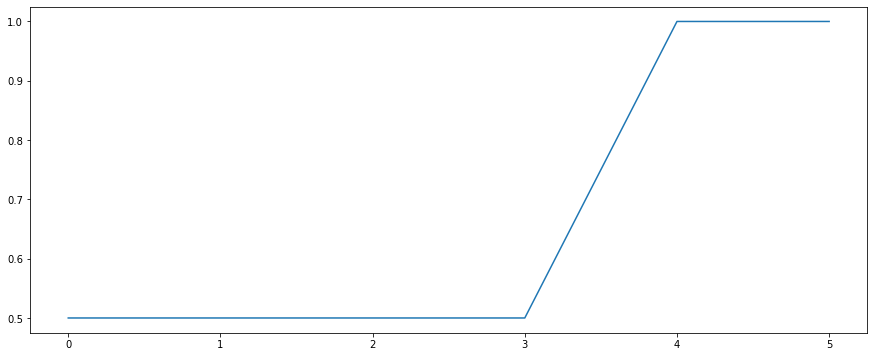

In [5]:
# Parametrización del algorítmo

estimador = PCA(n_components = 2)
x_pca = estimador.fit_transform(df_escalado)
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(x_pca)

minpts = 5
if(minpts>df_escalado['Id'].count()):
    minpts = df_escalado['Id'].count()-1
    
a = kneighbors_graph(x_pca, minpts, include_self=False)

ar = a.toarray()
seq = []

for i,s in enumerate(x_pca):
    for j in range(len(x_pca)):
        if ar[i][j] != 0:
            seq.append(matsim[i][j])
seq.sort()
plt.plot(seq)
plt.show()

#### Representación Gráfica de los Gupos y Outliers

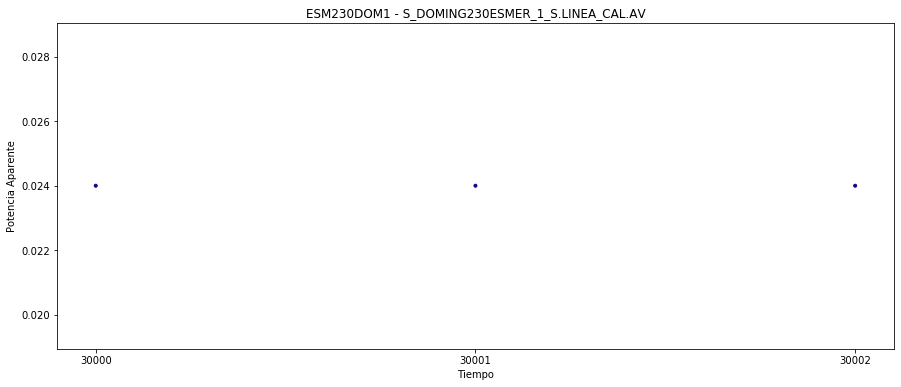

In [6]:
# Graficando los datos outliers

plt.scatter(datos['Id'],datos['Potencia'],c=clusters,cmap='plasma',marker='.')
plt.title(circuito+' - '+tag)
plt.xlabel('Tiempo')
plt.ylabel(dimension)
plt.show()

#### Datos de los Clusters y de los valores outliers

In [7]:
# Presentación de los grupos.

resumen = pd.DataFrame()
resumen['Id'] = datos['Id']
resumen['Potencia'] = datos['Potencia']
resumen['Label'] = clusters
grupos = pd.DataFrame()
grupos['Cantidad'] = resumen.groupby('Label').size()
grupos

,Cantidad
Label,
0,3


#### Descripción de los datos Obtenidos

In [8]:
# Descripcón de los datos de salida

datos = datosDestino[['Id','Potencia']].copy()
outliers = resumen[resumen['Label']==-1]
datos_limpios = resumen.drop(outliers.index)

print(datos.describe())
print('================================= Datos')
print(outliers.describe())
print('================================= Ouliers')
print(datos_limpios.describe())
print('================================= Datos Limpios')

       Potencia
count     3.000
mean      0.024
std       0.000
min       0.024
25%       0.024
50%       0.024
75%       0.024
max       0.024
================================= Datos
       Potencia  Label
count       0.0    0.0
mean        NaN    NaN
std         NaN    NaN
min         NaN    NaN
25%         NaN    NaN
50%         NaN    NaN
75%         NaN    NaN
max         NaN    NaN
================================= Ouliers
       Potencia  Label
count     3.000    3.0
mean      0.024    0.0
std       0.000    0.0
min       0.024    0.0
25%       0.024    0.0
50%       0.024    0.0
75%       0.024    0.0
max       0.024    0.0
================================= Datos Limpios


#### Gráfico para Visualizar los resultados

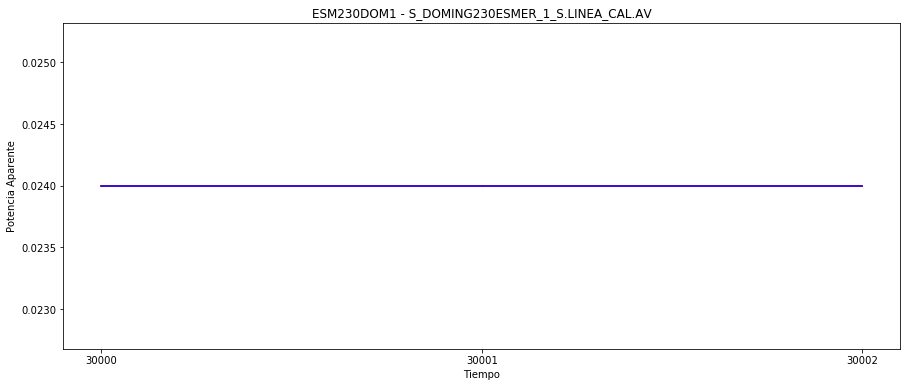

In [9]:
# Presentación de datos sin outliers

plt.plot(datos['Id'],datos['Potencia'],color="red",markersize=0.5,marker='.')
plt.plot(datos_limpios['Id'],datos_limpios['Potencia'],color="blue",markersize=0.05,marker='.')
plt.title(circuito+' - '+tag)
plt.xlabel('Tiempo')
plt.ylabel(dimension)
plt.show()

#### Gráfico BOXPLOT para visualizar los outliers

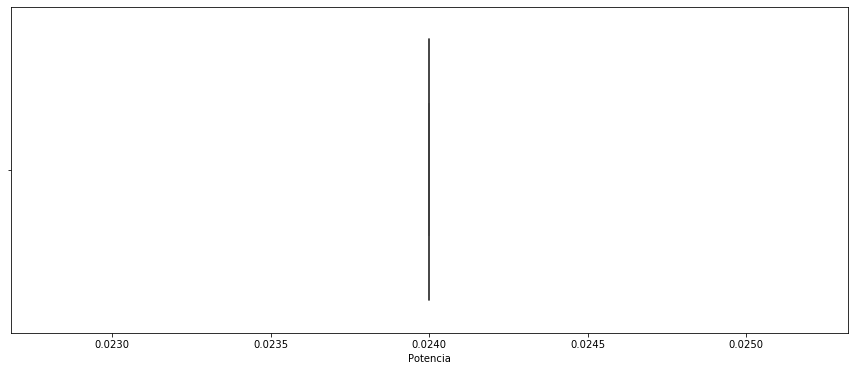

In [10]:
# Diagrama de cajas

sns.boxplot(datos['Potencia'])